## 1) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns

C:\Users\simon\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
# https://covid19.who.int/data
# https://health.google.com/covid-19/open-data/raw-data
# 3 methods: k-means, regression, HMMS (used to be naive bayes)

In [39]:
# reading in COVID-19 datasets
dem_df_raw = pd.read_csv('../data/demographics.csv')
eco_df_raw = pd.read_csv('../data/economy.csv')
epi_df_raw = pd.read_csv('../data/epidemiology.csv')
vac_df_raw = pd.read_csv('../data/vaccinations.csv')
hos_df_raw = pd.read_csv('../data/hospitalizations.csv')
gov_df_raw = pd.read_csv('../data/oxford-government-response.csv')
idx_df_raw = pd.read_csv('../data/index.csv')

## 2) Data Processing

In [40]:
dem_df = dem_df_raw
eco_df = eco_df_raw
epi_df = epi_df_raw
vac_df = vac_df_raw
hos_df = hos_df_raw
gov_df = gov_df_raw
idx_df = idx_df_raw

In [19]:
# get_distance: gets the distance between a data point and a mean (208 dimensions)
# inputs: data point and mean centroid
# output: the distance
def get_distance(data_row, k_row):
    sum = 0
    for i in range(len(data_row)): #208
        sum += ((data_row[i] - k_row[i]) ** 2)
    dist = sum ** 0.5
    return dist

In [20]:
# generate_clusters: labels every HIP data point with the cluster they belong to
# inputs: HIP data and test means data
# output: list of cluster labels for each HIP data point
def generate_clusters(hip_exp, test_means, k):
    cluster_ids = []
    objective = 0.0
    
    # go through all data points
    for d_row in range(len(hip_exp)):
        dists = []
        
        # compare the distances between data point and each of the k centroids
        for k_row in range(k):
            dist = get_distance(hip_exp[d_row], test_means[k_row])
            dists.append(dist)            

        # assign data point to closest mean (centroid)
        min_dist = np.min(dists)
        objective += min_dist
        cluster_ids.append(np.where(dists == min_dist)[0][0])
    
    return cluster_ids

In [21]:
# update_means: updates the positions of the centroids
# inputs: cluster labels and HIP data
# output: the new positions of the mean centroids
def update_means(cluster_ids, hip_exp, k):
    new_means = np.zeros((k, hip_exp.shape[1]))
    
    # range through the data and take the mean, column by column,
    # by data point rows that are in the same cluster
    for j in range(hip_exp.shape[1]): #208
        
        for k_num in range(k):
            curr_list = []
            
            for i in range(len(cluster_ids)): #879
                if cluster_ids[i] == k_num:
                    curr_list.append(hip_exp[i][j])

            if len(curr_list) > 0:
                new_means[k_num][j] = np.mean(curr_list)
            
    return new_means

In [22]:
# get_objective: computes the objective value from the data, given the current centroid positions
# inputs: HIP data, updated centroid means, cluster labels for each data point
# output: the objective value
def get_objective(hip_exp, means, cluster_ids, k):
   
    objective = 0
    
    # compute objective (add up all intracluster distances, then add up those sums for each cluster)
    for k_num in range(k):
        intra_cluster_sum = 0
        for i in range(len(cluster_ids)): # 879
            if cluster_ids[i] == k_num:
                intra_cluster_sum += (get_distance(means[k_num], hip_exp[i]) ** 2)
        objective += intra_cluster_sum
    
    return objective

In [23]:
# run_k_means: run the k-means algorithm (repeatedly generating clusters and updating means
#              until centroids do not change or max iterations reached)
# inputs: HIP data and initial means
# output: cluster labels, updated means, updated objective values
def run_k_means(hip_exp, test_means, k):
    means = test_means
    count = 0
    objectives = []
    prev_cluster_ids = []
    
    # keep running k means until a stopping condition is meant
    while(True):
        count += 1
        
        # generate clusters
        cluster_ids = generate_clusters(hip_exp, means, k)
        # update means
        means = update_means(cluster_ids, hip_exp, k)
        
        # compute and track objective score
        objective = get_objective(hip_exp, means, cluster_ids, k)
        objectives.append(objective)
        
        # stopping condition: all points remain in the same cluster
        if cluster_ids == prev_cluster_ids:
            #print("BREAK: points remain in same cluster")
            break;
        
        # track previous cluster labels for stopping condition
        prev_cluster_ids = cluster_ids
    
        # stopping condition: max iterations reached
        if count == 50:
            #print("BREAK: max iteration reached")
            break
            
    return cluster_ids, means, objectives

In [48]:
def select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country):
    gov_df['location_key'] = gov_df['location_key'].str.slice(0,2)
    gov_df = gov_df.loc[gov_df['location_key'] == country]
    gov_df_agg = gov_df.groupby(['location_key', 'date']).mean()
    #gov_day_agg
    epi_df['location_key'] = epi_df['location_key'].str.slice(0,2)
    epi_df = epi_df.loc[epi_df['location_key'] == country]
    epi_df_agg = epi_df.groupby(['location_key', 'date']).sum()
    #epi_day_agg
    vac_df['location_key'] = vac_df['location_key'].str.slice(0,2)
    vac_df = vac_df.loc[vac_df['location_key'] == country]
    vac_df_agg = vac_df.groupby(['location_key', 'date']).sum()
    #vac_day_agg
    hos_df['location_key'] = hos_df['location_key'].str.slice(0,2)
    hos_df = hos_df.loc[hos_df['location_key'] == country]
    hos_df_agg = hos_df.groupby(['location_key', 'date']).sum()
    
    return gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg

In [49]:
def merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg):
    # checkpoint dataset
    covid_merged_df = epi_df_agg.merge(vac_df_agg.merge(hos_df_agg.merge(gov_df_agg, on='date', how='outer'), on='date', how='outer'), on='date', how='outer')
    return covid_merged_df

In [64]:
covid_merged_df.columns

Index(['new_confirmed', 'new_deceased', 'new_recovered', 'new_tested',
       'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered',
       'cumulative_tested', 'new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated',
       'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered',
       'cumulative_vaccine_doses_administered',
       'new_persons_vaccinated_pfizer', 'cumulative_persons_vaccinated_pfizer',
       'new_persons_fully_vaccinated_pfizer',
       'cumulative_persons_fully_vaccinated_pfizer',
       'new_vaccine_doses_administered_pfizer',
       'cumulative_vaccine_doses_administered_pfizer',
       'new_persons_vaccinated_moderna',
       'cumulative_persons_vaccinated_moderna',
       'new_persons_fully_vaccinated_moderna',
       'cumulative_persons_fully_vaccinated_moderna',
       'new_vaccine_doses_administered_moderna',
       'cumulative_vaccine_doses_administered_moderna',
       'new_persons_

In [163]:
# main code start
country = 'US'
gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg = select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country)
covid_merged_df = merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg)
#covid_agg_unnorm_df = covid_agg_unnorm_df.merge(dem_df_agg, on='date', how='outer')
covid_merged_mini_df = covid_merged_df[['new_deceased', 'new_persons_vaccinated', 'new_hospitalized_patients', 'new_persons_fully_vaccinated', 'new_intensive_care_patients']]
covid_norm_df = (covid_merged_mini_df-covid_merged_mini_df.mean())/covid_merged_mini_df.std()

In [84]:
(~covid_norm_df.isnull().any(axis=1)).tolist()

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [164]:
covid_norm_df_nonan = covid_norm_df[~covid_norm_df.isnull().any(axis=1)]

In [165]:
# for k means
covid_mtx = covid_norm_df_nonan.to_numpy()

In [166]:
covid_mtx

array([[ 0.63573466, -0.78279624,  1.59058626, -0.40727778,  0.40013742],
       [ 0.6694701 , -0.80928533,  1.62837266, -0.40721465,  2.03034767],
       [ 1.95976353, -0.76761685,  2.1707369 , -0.40714975,  2.89804022],
       ...,
       [-0.72272522, -0.81019354, -0.32471832, -0.40727778, -0.58587685],
       [-0.48275151, -0.81385961, -0.27958169, -0.40727778, -0.58587685],
       [-0.81036779, -0.81385961, -0.27937464, -0.40727778, -0.58587685]])

In [167]:
covid_mtx.shape

(642, 5)

In [168]:
# for k means
covid_mtx = covid_norm_df_nonan.to_numpy()
date_list = covid_norm_df_nonan.index.tolist()
# covid_mtx
# covid_mtx2 = covid_mtx[~np.isnan(covid_mtx[:,1])]
# date_list = covid_norm_df_nonan.index.tolist()
# date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 4
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(covid_mtx, rand_means, k)
clusters = k_means_results[0]

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df

In [169]:
covid_stringency_final_df

,stringency_index,clusters
date,,
2020-12-13,58.822500,0
2020-12-14,59.240962,0
2020-12-15,59.240962,0
2020-12-16,59.428077,0
2020-12-17,59.401346,0
...,...,...
2022-09-11,0.000000,3
2022-09-12,0.000000,3
2022-09-13,0.000000,3


In [170]:
# for stringency stuff
covid_stringency_df = covid_merged_df[['new_confirmed']]
covid_stringency_agg_df  = covid_stringency_df.groupby(['date']).sum()
#covid_stringency_final_df = covid_stringency_agg_df[~np.isnan(covid_mtx[:,1])]
covid_stringency_final_df = covid_stringency_agg_df[~covid_norm_df.isnull().any(axis=1)]

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df

C:\Users\simon\AppData\Local\Temp\ipykernel_33720\34055851.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  covid_stringency_final_df = covid_stringency_agg_df[~covid_norm_df.isnull().any(axis=1)]


,new_confirmed,clusters
date,,
2020-12-13,547152.0,2
2020-12-14,594769.0,0
2020-12-15,602492.0,0
2020-12-16,725693.0,0
2020-12-17,723638.0,0
...,...,...
2022-09-11,30473.0,1
2022-09-12,152889.0,1
2022-09-13,118839.0,1


Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

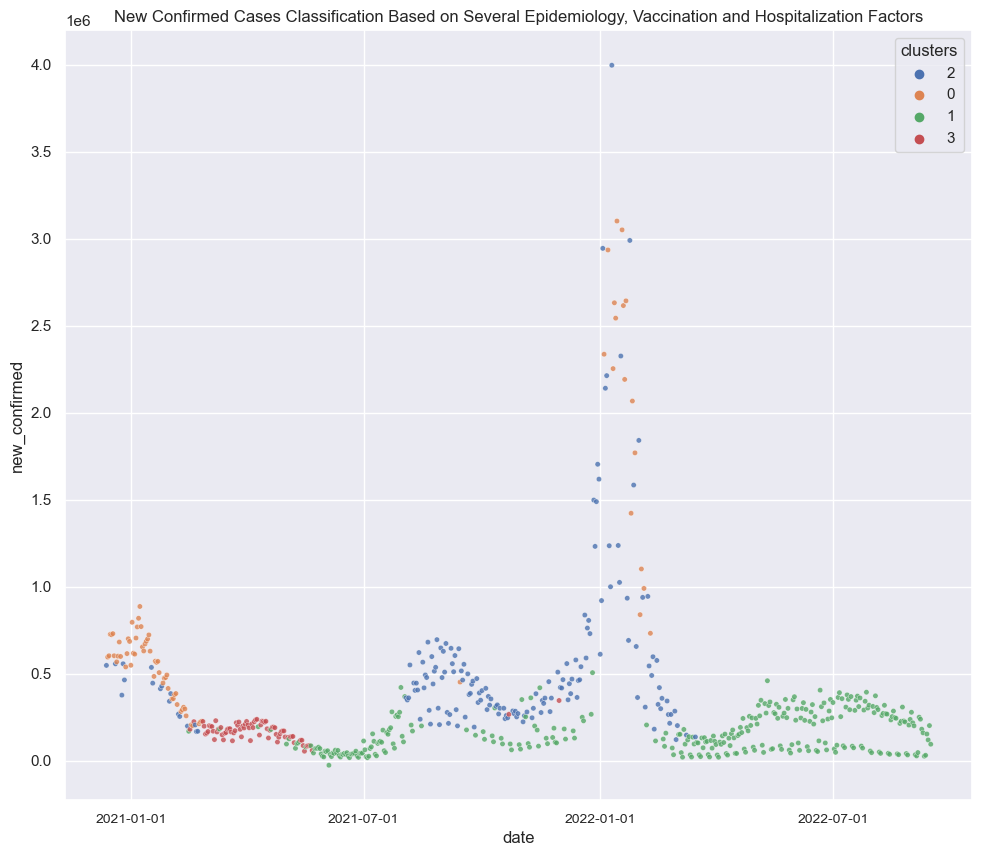

In [171]:
# this plot is important

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df
sns.scatterplot(data = covid_stringency_final_df, x='date', y='new_confirmed', hue='clusters', s=15, alpha=0.8)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

## Getting true labels by clustering just stringency

In [ ]:
# covid_norm_df.index.isin(merged_final_df.index.values.tolist())
# covid_st_only_df = covid_stringency_only_df[~covid_stringency_only_df.isnull().any(axis=1)]
# covid_st_only_df.head(3)
# st_mtx = covid_st_only_df.to_numpy()
# date_list = covid_st_only_df.index.tolist()
# #date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
# k = 4
# rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

# k_means_results = run_k_means(st_mtx, rand_means, k)
# clusters = k_means_results[0]
# # clusters

# # date_list2

# # clusters = k_means_results[0]
# # countries = covid_norm_df.index.tolist()
# # mini_idx_df = idx_df[['location_key', 'country_name']]
# d = {'date': date_list,'clusters': clusters}
# st_clustered_dates_df = pd.DataFrame(d)
# #clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# # clustered_countries_name_df
# covid_st_only_df['clusters'] = (st_clustered_dates_df['clusters'].values).astype(str)
# covid_st_only_df
# # this plot is important
# sns.scatterplot(data = covid_st_only_df, x='date', y='new_confirmed', hue='clusters', s=15, alpha=0.8)
# sns.set(rc={'figure.figsize':(11.7,10.0)})
# plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
# plt.title('True Clustering for New Confirmed Case Amounts')

In [172]:
covid_stringency_only_df = covid_merged_df[['new_confirmed']]

In [173]:
covid_st_only_df = covid_stringency_only_df[~covid_stringency_only_df.isnull().any(axis=1)]

In [174]:
covid_st_only_df.head(3)

,new_confirmed
date,
2020-01-01,0.0
2020-01-02,0.0
2020-01-03,0.0


In [175]:
st_mtx = covid_st_only_df.to_numpy()

In [201]:
date_list = covid_st_only_df.index.tolist()
#date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 3
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(st_mtx, rand_means, k)
clusters = k_means_results[0]
# clusters

# date_list2

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
st_clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df

In [202]:
covid_st_only_df['clusters'] = (st_clustered_dates_df['clusters'].values).astype(str)
covid_st_only_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,2
2020-12-14,594769.0,2
2020-12-15,602492.0,2
2020-12-16,725693.0,2
2020-12-17,723638.0,2
...,...,...
2022-07-21,310512.0,1
2022-07-22,360068.0,1
2022-07-23,83417.0,1


Text(0.5, 1.0, 'True Clustering for New Confirmed Case Amounts')

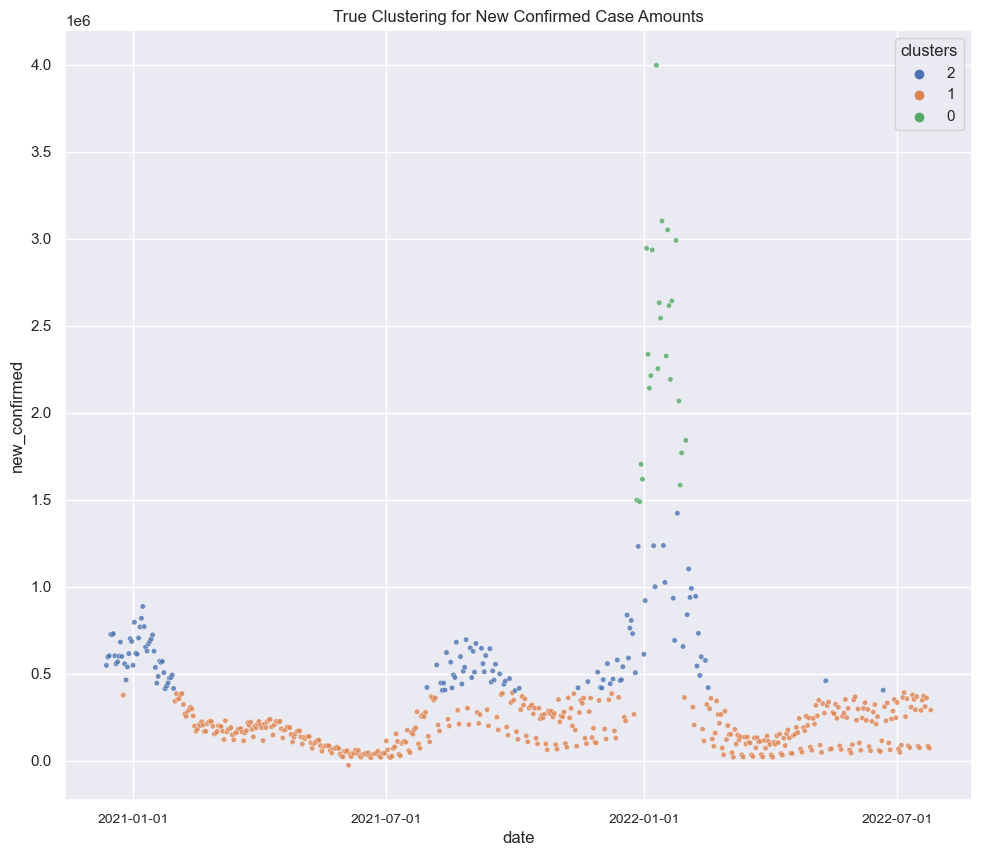

In [203]:
# this plot is important
sns.scatterplot(data = covid_st_only_df, x='date', y='new_confirmed', hue='clusters', s=15, alpha=0.8)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for New Confirmed Case Amounts')

In [206]:
merged_final_df = covid_st_only_df.merge(covid_stringency_final_df, on='date', how='inner')
merged_final_df.columns = ['stringency', 'true_cluster_id', 'stringency_dupe', 'pred_cluster_id']
merged_final_df

,stringency,true_cluster_id,stringency_dupe,pred_cluster_id
date,,,,
2020-12-13,547152.0,2,547152.0,0
2020-12-14,594769.0,2,594769.0,3
2020-12-15,602492.0,2,602492.0,3
2020-12-16,725693.0,2,725693.0,3
2020-12-17,723638.0,2,723638.0,3
...,...,...,...,...
2022-07-21,310512.0,1,310512.0,2
2022-07-22,360068.0,1,360068.0,2
2022-07-23,83417.0,1,83417.0,2


In [205]:
merged_final_df.index.values

array(['2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
       '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
       '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
       '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
       '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
       '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
       '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
       '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
       '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
       '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
       '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25',
       '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29',
       '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02',
       '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06',
       '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10',
       '2021-02-11', '2021-02-12', '2021-02-13', '2021-

In [181]:
#df[df.index.isin(myDates)]
# merged df
covid_norm_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]

,new_deceased,new_persons_vaccinated,new_hospitalized_patients,new_persons_fully_vaccinated,new_intensive_care_patients
date,,,,,
2020-12-13,0.635735,-0.782796,1.590586,-0.407278,0.400137
2020-12-14,0.669470,-0.809285,1.628373,-0.407215,2.030348
2020-12-15,1.959764,-0.767617,2.170737,-0.407150,2.898040
2020-12-16,2.571523,-0.657804,2.037190,-0.407062,3.082096
2020-12-17,2.446319,-0.544843,1.973730,-0.406929,2.674544
...,...,...,...,...,...
2022-07-21,-0.700467,-0.269822,0.243527,-0.061618,-0.585877
2022-07-22,-0.640299,-0.739393,0.237212,-0.407278,-0.585877
2022-07-23,-0.984262,-0.774894,0.153978,-0.407278,-0.585877


In [207]:
# start here!

In [218]:
covid_norm_df_nonan = covid_norm_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
# for k means
covid_mtx = covid_norm_df_nonan.to_numpy()
date_list = covid_norm_df_nonan.index.tolist()
# covid_mtx
# covid_mtx2 = covid_mtx[~np.isnan(covid_mtx[:,1])]
# date_list = covid_norm_df_nonan.index.tolist()
# date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 3
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(covid_mtx, rand_means, k)
clusters = k_means_results[0]

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df

In [220]:
# for stringency stuff
covid_stringency_df = covid_merged_df[['new_confirmed']]
covid_stringency_agg_df  = covid_stringency_df.groupby(['date']).sum()
#covid_stringency_final_df = covid_stringency_agg_df[~np.isnan(covid_mtx[:,1])]
covid_stringency_final_df = covid_stringency_agg_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,0
2020-12-14,594769.0,0
2020-12-15,602492.0,0
2020-12-16,725693.0,0
2020-12-17,723638.0,0
...,...,...
2022-07-21,310512.0,2
2022-07-22,360068.0,2
2022-07-23,83417.0,2


Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

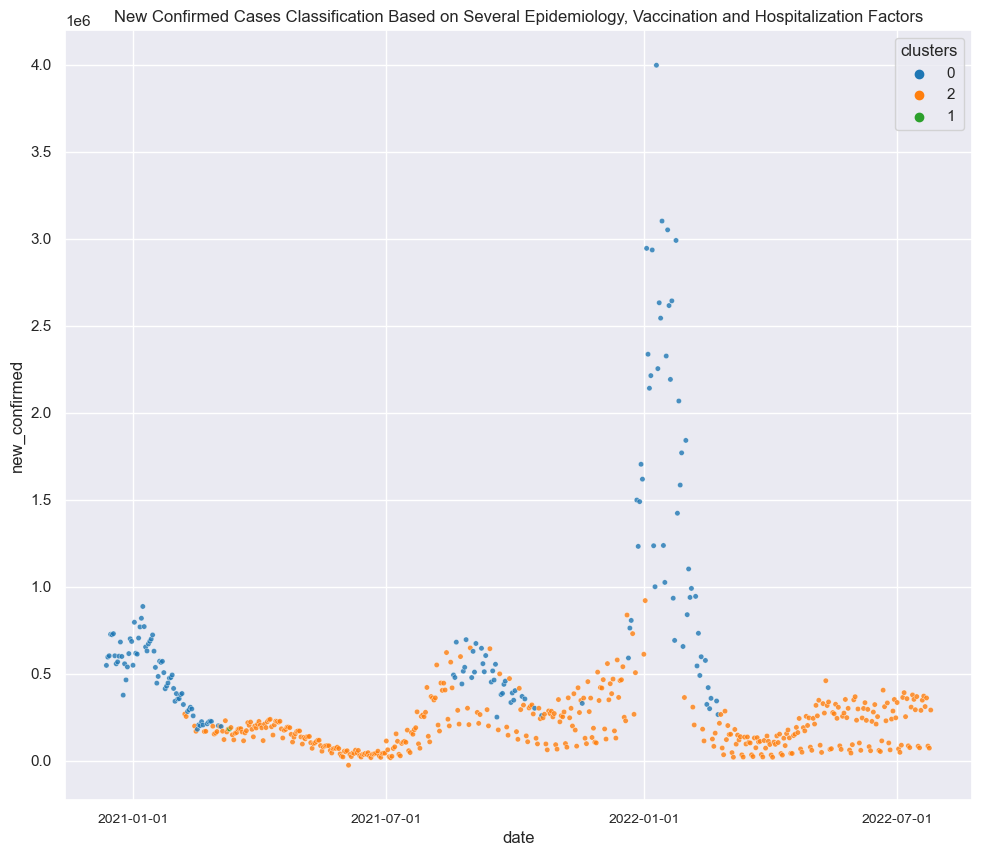

In [221]:
# this plot is important

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df
palette = {
    '0': 'tab:blue',
    '1': 'tab:green',
    '2': 'tab:orange',
    #'3': 'tab:red',
}
sns.scatterplot(data = covid_stringency_final_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=0.8)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [222]:
covid_norm_df.index.isin(merged_final_df.index.values.tolist())
covid_st_only_df = covid_stringency_only_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
covid_st_only_df.head(3)
st_mtx = covid_st_only_df.to_numpy()
date_list = covid_st_only_df.index.tolist()
#date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 3
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(st_mtx, rand_means, k)
clusters = k_means_results[0]
# clusters

# date_list2

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
st_clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df
covid_st_only_df['clusters'] = (st_clustered_dates_df['clusters'].values).astype(str)
covid_st_only_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,0
2020-12-14,594769.0,0
2020-12-15,602492.0,0
2020-12-16,725693.0,0
2020-12-17,723638.0,0
...,...,...
2022-07-21,310512.0,1
2022-07-22,360068.0,1
2022-07-23,83417.0,1


Text(0.5, 1.0, 'True Clustering for New Confirmed Case Amounts')

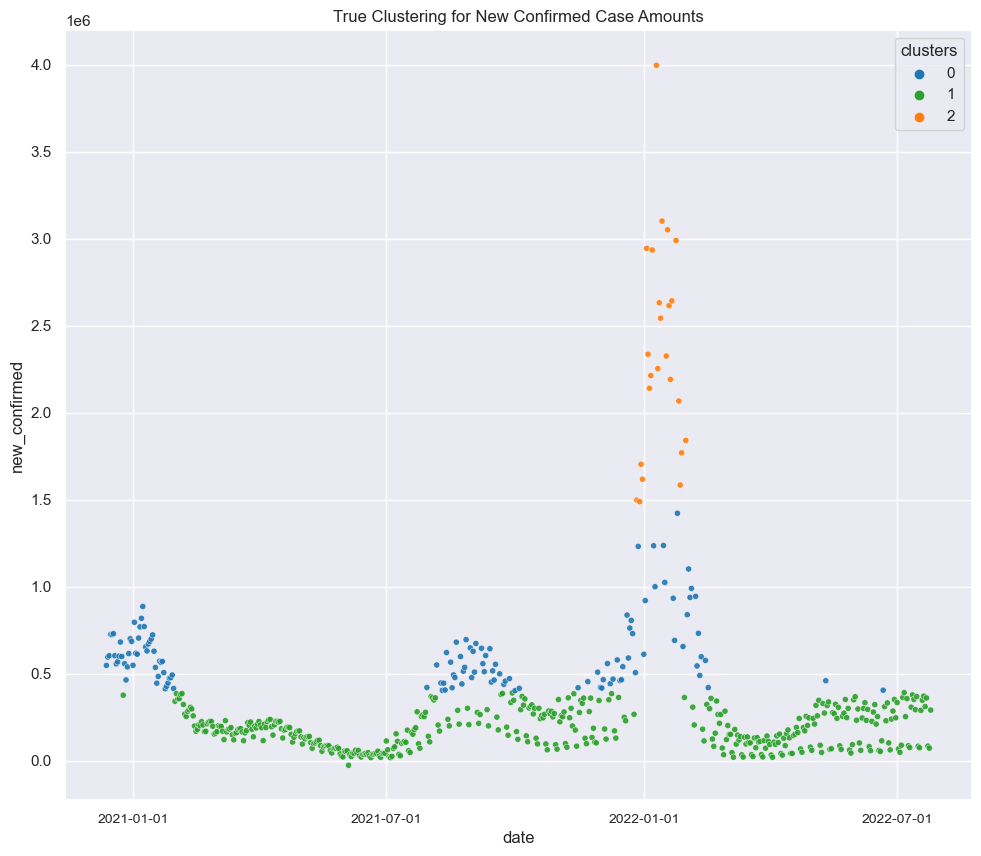

In [241]:
palette = {
    '0': 'tab:blue',
    '1': 'tab:green',
    '2': 'tab:orange',
    #'3': 'tab:red',
}
# this plot is important
sns.scatterplot(data = covid_st_only_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=20, alpha=0.9)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for New Confirmed Case Amounts')

In [224]:
covid_st_only_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,0
2020-12-14,594769.0,0
2020-12-15,602492.0,0
2020-12-16,725693.0,0
2020-12-17,723638.0,0
...,...,...
2022-07-21,310512.0,1
2022-07-22,360068.0,1
2022-07-23,83417.0,1


In [225]:
covid_stringency_final_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,0
2020-12-14,594769.0,0
2020-12-15,602492.0,0
2020-12-16,725693.0,0
2020-12-17,723638.0,0
...,...,...
2022-07-21,310512.0,2
2022-07-22,360068.0,2
2022-07-23,83417.0,2


In [227]:
true_df = covid_st_only_df
pred_df = covid_stringency_final_df

In [228]:
pred_df['clusters'] = pred_df['clusters'].replace(['2'], 'A')
pred_df['clusters'] = pred_df['clusters'].replace(['1'], 'B')
pred_df['clusters'] = pred_df['clusters'].replace(['A'], '1')
pred_df['clusters'] = pred_df['clusters'].replace(['B'], '2')

Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

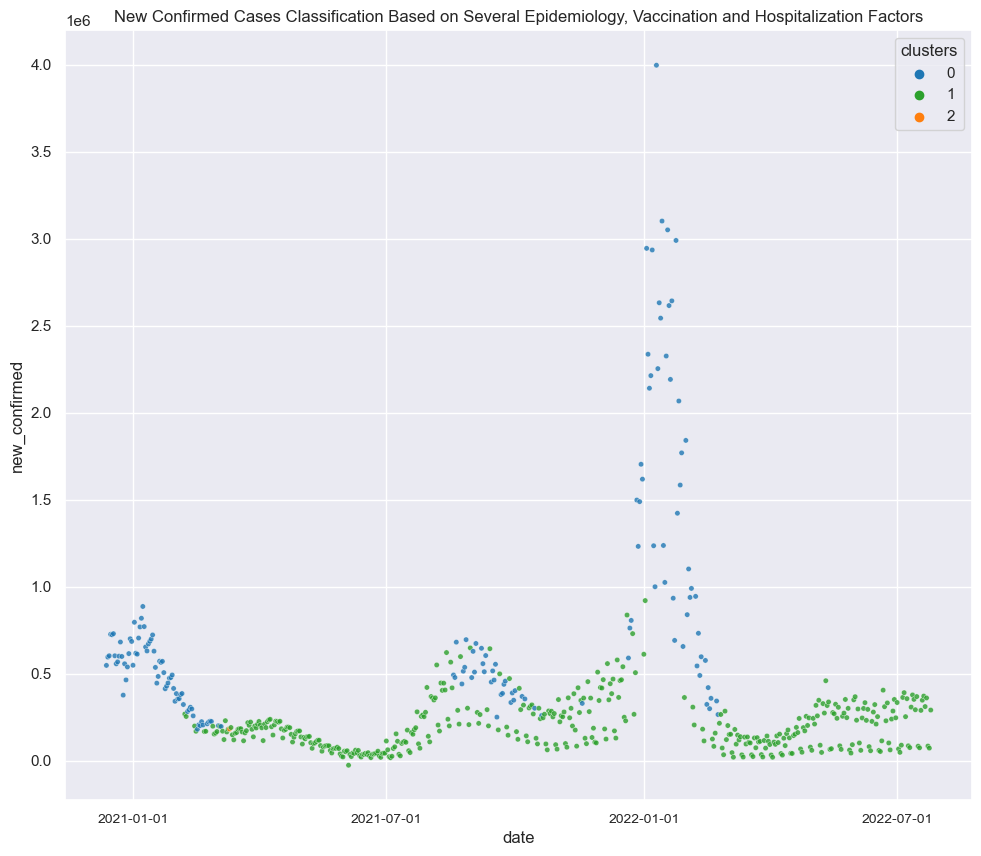

In [229]:
# predictions graph, but recoded to match 'true' labels
sns.scatterplot(data = pred_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=20, alpha=0.9)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [239]:
eval_dict = {'pred_cluster_id': pred_df['clusters'],'true_cluster_id': true_df['clusters']}
eval_df = pd.DataFrame(eval_dict)
eval_df['match'] = eval_df['pred_cluster_id'] == eval_df['true_cluster_id']
np.sum(eval_df['match']) / eval_df.shape[0]

0.8305084745762712

In [240]:
eval_df

,pred_cluster_id,true_cluster_id,match
date,,,
2020-12-13,0,0,True
2020-12-14,0,0,True
2020-12-15,0,0,True
2020-12-16,0,0,True
2020-12-17,0,0,True
...,...,...,...
2022-07-21,1,1,True
2022-07-22,1,1,True
2022-07-23,1,1,True


### elbow plots

In [245]:
# Not used currently!!!
# create_objectives_plot: plot objective values over iterations
# inputs: objective values from K means and title of the plot
# output: the plot itself
def create_objectives_plot(objectives, title):
    objective = objectives[len(objectives)-1]
    index_len = len(objectives) + 1
    index = list(range(1, index_len))
    plt.scatter(index, objectives)
    plt.title(str(round(objective, 1)) + " : "+ title)
    plt.xlabel("Iterations")
    plt.ylabel("Objective Score")
    return plt.plot(index, objectives)

In [263]:
# making the elbow plot
ks = []
last_objs = []
for i in range(2, 15):
    k = i
    print(k)
    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(covid_mtx, rand_means, k)
    clusters, means, objectives = k_means_results
    best_obj = objectives[len(objectives)-1]
    for trial in range(9):
        rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
        k_means_results = run_k_means(covid_mtx, rand_means, k)
        clusters, means, objectives = k_means_results
        curr_obj = objectives[len(objectives)-1]
        if curr_obj < best_obj:
            best_obj = curr_obj
    ks.append(k)
    last_objs.append(best_obj)

2
3
4
5
6
7
8
9
10
11
12
13
14


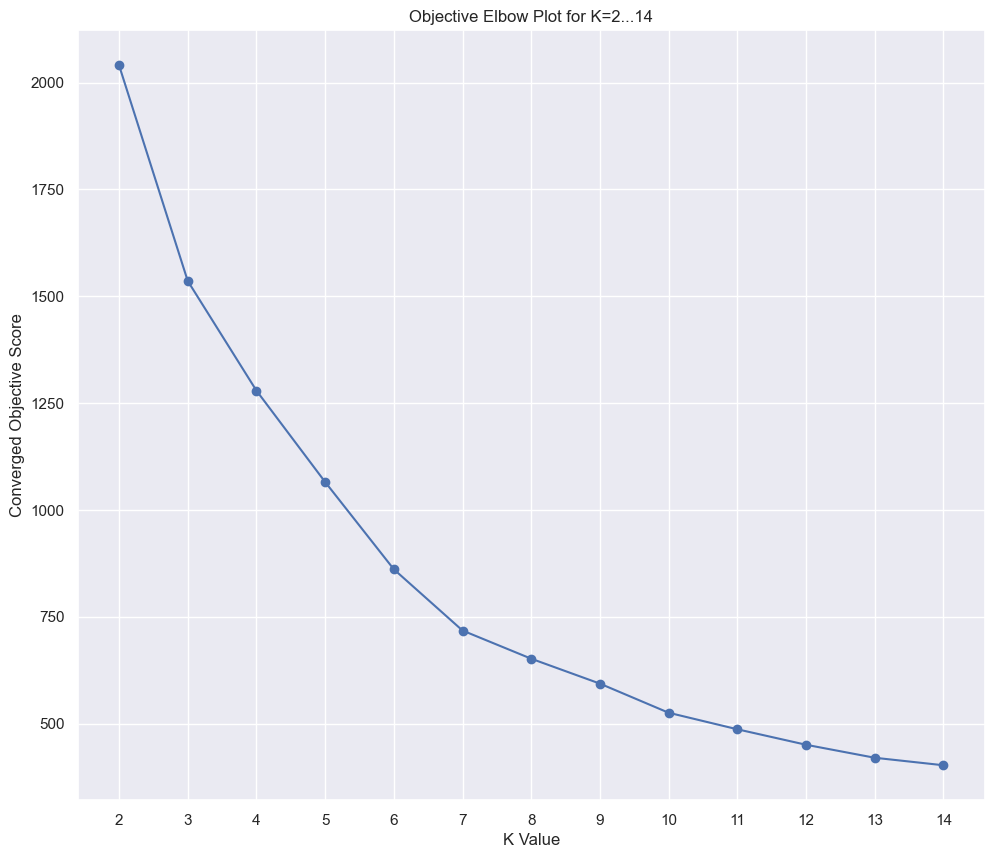

In [265]:
plt.scatter(ks, last_objs)
plt.xlabel('K Value')
plt.ylabel('Converged Objective Score')
plt.title('Objective Elbow Plot for K=2...14')
plt.xticks(range(2, 15))
plt.plot(ks, last_objs)

## k = 7 clusters

In [266]:
covid_norm_df_nonan = covid_norm_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
# for k means
covid_mtx = covid_norm_df_nonan.to_numpy()
date_list = covid_norm_df_nonan.index.tolist()
# covid_mtx
# covid_mtx2 = covid_mtx[~np.isnan(covid_mtx[:,1])]
# date_list = covid_norm_df_nonan.index.tolist()
# date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 7
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(covid_mtx, rand_means, k)
clusters = k_means_results[0]

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df

In [267]:
# for stringency stuff
covid_stringency_df = covid_merged_df[['new_confirmed']]
covid_stringency_agg_df  = covid_stringency_df.groupby(['date']).sum()
#covid_stringency_final_df = covid_stringency_agg_df[~np.isnan(covid_mtx[:,1])]
covid_stringency_final_df = covid_stringency_agg_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,1
2020-12-14,594769.0,6
2020-12-15,602492.0,6
2020-12-16,725693.0,6
2020-12-17,723638.0,6
...,...,...
2022-07-21,310512.0,4
2022-07-22,360068.0,4
2022-07-23,83417.0,4


Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

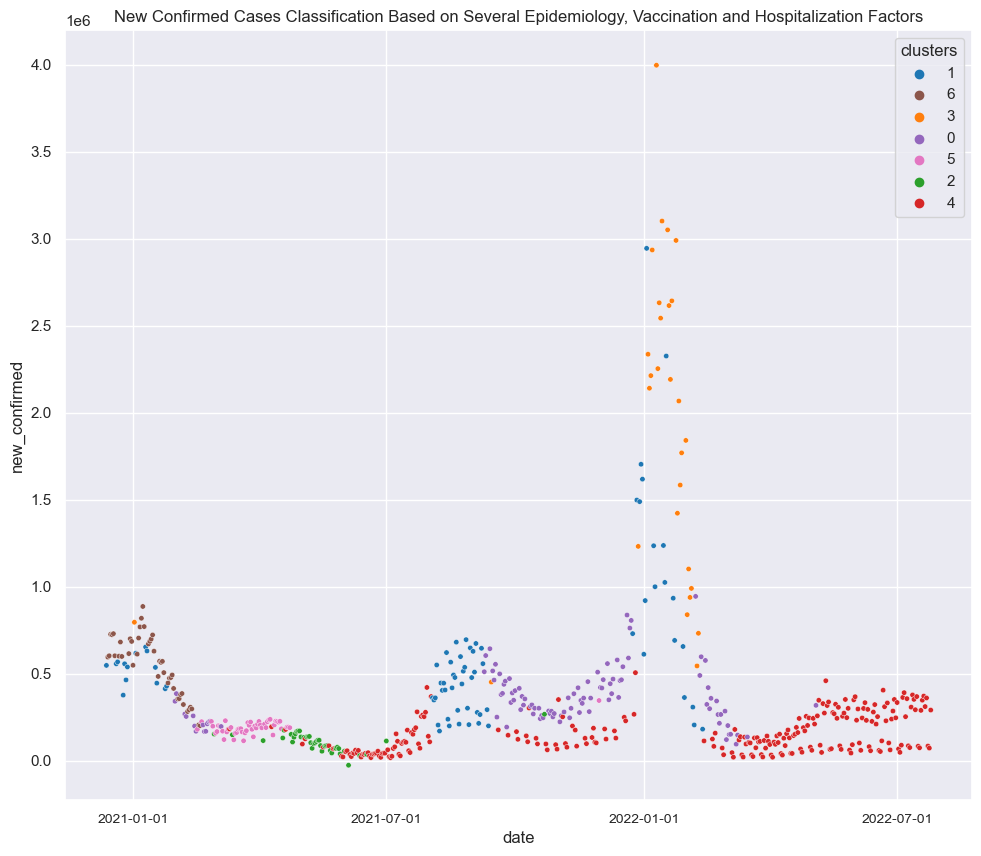

In [291]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df
sns.scatterplot(data = covid_stringency_final_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [270]:
covid_norm_df.index.isin(merged_final_df.index.values.tolist())
covid_st_only_df = covid_stringency_only_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
covid_st_only_df.head(3)
st_mtx = covid_st_only_df.to_numpy()
date_list = covid_st_only_df.index.tolist()
#date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 7
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(st_mtx, rand_means, k)
clusters = k_means_results[0]
# clusters

# date_list2

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
st_clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df
covid_st_only_df['clusters'] = (st_clustered_dates_df['clusters'].values).astype(str)
covid_st_only_df

,new_confirmed,clusters
date,,
2020-12-13,547152.0,2
2020-12-14,594769.0,2
2020-12-15,602492.0,2
2020-12-16,725693.0,1
2020-12-17,723638.0,1
...,...,...
2022-07-21,310512.0,3
2022-07-22,360068.0,3
2022-07-23,83417.0,6


Text(0.5, 1.0, 'True Clustering for New Confirmed Case Amounts')

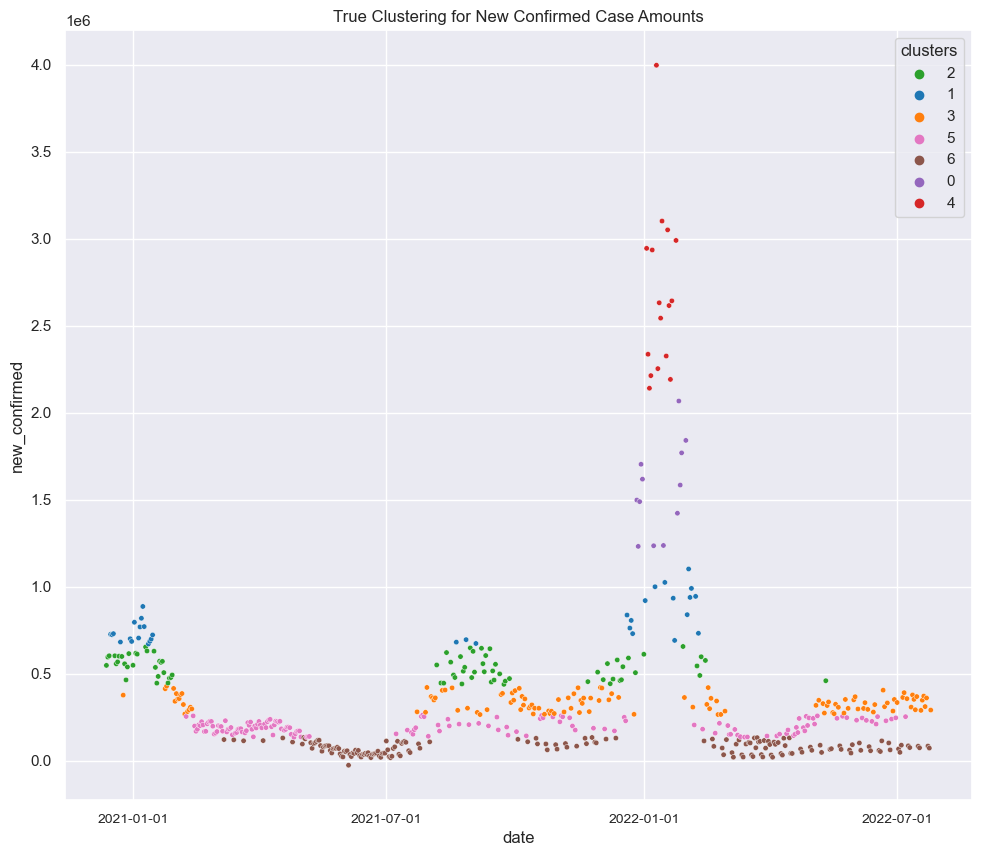

In [290]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}
sns.scatterplot(data = covid_st_only_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for New Confirmed Case Amounts')

In [292]:
cluster_means_pred_df = covid_stringency_final_df.groupby(['clusters']).mean()
cluster_means_pred_df.sort_values(by=['new_confirmed'], ascending=False)

,new_confirmed
clusters,
3,1.926218e+06
1,6.240323e+05
6,5.500536e+05
0,3.600235e+05
5,1.924870e+05
4,1.529932e+05
2,1.072436e+05


In [293]:
pred_df = covid_stringency_final_df
true_df = covid_st_only_df

In [294]:
pred_df['clusters'] = pred_df['clusters'].replace(['0'], 'A')
pred_df['clusters'] = pred_df['clusters'].replace(['1'], 'B')
pred_df['clusters'] = pred_df['clusters'].replace(['2'], 'C')
pred_df['clusters'] = pred_df['clusters'].replace(['3'], 'D')
pred_df['clusters'] = pred_df['clusters'].replace(['4'], 'E')
pred_df['clusters'] = pred_df['clusters'].replace(['5'], 'F')
pred_df['clusters'] = pred_df['clusters'].replace(['6'], 'G')

pred_df['clusters'] = pred_df['clusters'].replace(['A'], '2')
pred_df['clusters'] = pred_df['clusters'].replace(['B'], '0')
pred_df['clusters'] = pred_df['clusters'].replace(['C'], '6')
pred_df['clusters'] = pred_df['clusters'].replace(['D'], '4')
pred_df['clusters'] = pred_df['clusters'].replace(['E'], '5')
pred_df['clusters'] = pred_df['clusters'].replace(['F'], '3')
pred_df['clusters'] = pred_df['clusters'].replace(['G'], '1')

Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

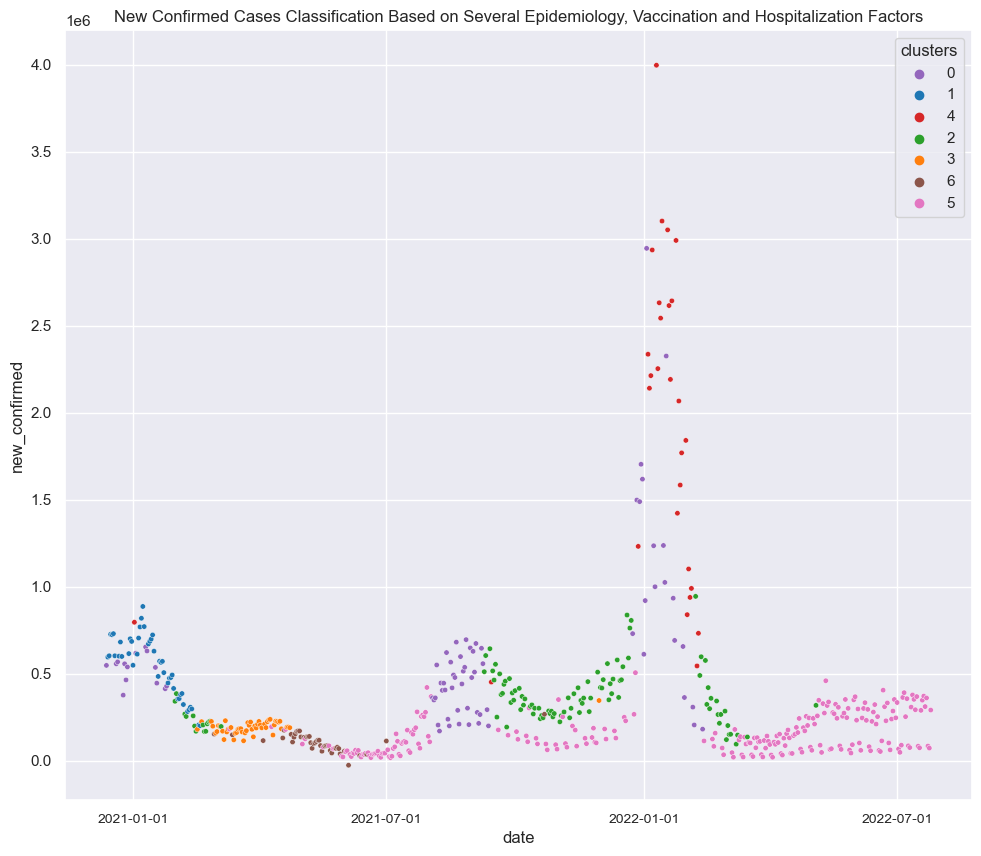

In [296]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}
sns.scatterplot(data = pred_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [297]:
eval_dict = {'pred_cluster_id': pred_df['clusters'],'true_cluster_id': true_df['clusters']}
eval_df = pd.DataFrame(eval_dict)
eval_df['match'] = eval_df['pred_cluster_id'] == eval_df['true_cluster_id']
np.sum(eval_df['match']) / eval_df.shape[0]

0.24915254237288137

### extra (ignore)

Text(0.5, 1.0, 'True Clustering for Stringency Index')

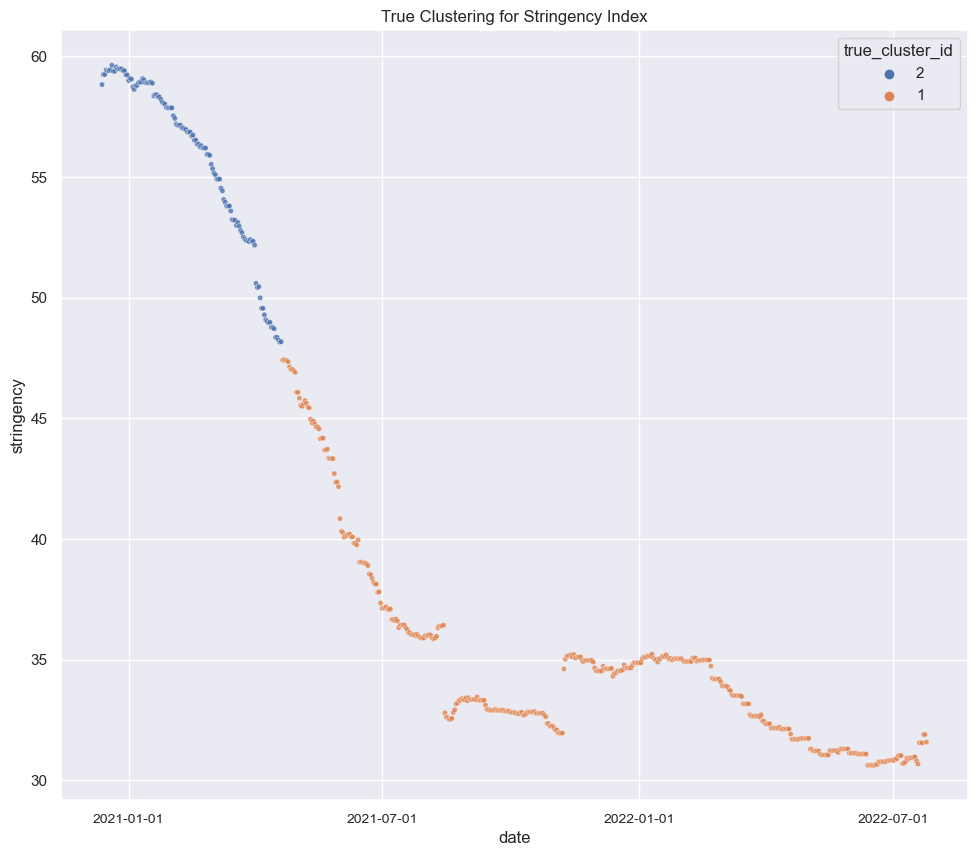

In [150]:
# this plot is important
sns.scatterplot(data = merged_final_df, x='date', y='stringency', hue='true_cluster_id', s=15, alpha=0.8)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for Stringency Index')